In [30]:
import datetime
import os
from typing import Callable, Optional
import pandas as pd
from sklearn import preprocessing
import numpy as np
import torch

In [31]:
pd.set_option('display.max_columns', None)
path = '../../../archive/HI-Small_Trans.csv'
#path = './archive/LI-Small_Trans.csv'
df = pd.read_csv(path)

# 데이터확인
-> 우리의 피쳐 엔지니어링은 더 심오하다! 화이팅 ~!! ( 할껄? )
* 계정을 노드로, 거래를 에지로 간주하여 전체 데이터 세트를 노드 분류 문제로 변환할
* 의심스러운 계정을 분류하기 위해 모든 거래에서 수신자와 지불자의 모든 계정을 추출

In [32]:
df.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/09/01 00:20,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0
1,2022/09/01 00:20,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0
2,2022/09/01 00:00,3209,8000F4670,3209,8000F4670,14675.57,US Dollar,14675.57,US Dollar,Reinvestment,0
3,2022/09/01 00:02,12,8000F5030,12,8000F5030,2806.97,US Dollar,2806.97,US Dollar,Reinvestment,0
4,2022/09/01 00:06,10,8000F5200,10,8000F5200,36682.97,US Dollar,36682.97,US Dollar,Reinvestment,0


In [33]:
df.describe()

,From Bank,To Bank,Amount Received,Amount Paid,Is Laundering
count,5.078345e+06,5.078345e+06,5.078345e+06,5.078345e+06,5.078345e+06
mean,4.573057e+04,6.574456e+04,5.988726e+06,4.509273e+06,1.019427e-03
std,8.176562e+04,8.409299e+04,1.037183e+09,8.697728e+08,3.191219e-02
min,1.000000e+00,1.000000e+00,1.000000e-06,1.000000e-06,0.000000e+00
25%,1.190000e+02,4.259000e+03,1.833700e+02,1.844800e+02,0.000000e+00
50%,9.679000e+03,2.156800e+04,1.411010e+03,1.414540e+03,0.000000e+00
75%,2.862800e+04,1.223320e+05,1.234627e+04,1.229784e+04,0.000000e+00
max,3.563030e+05,3.562940e+05,1.046302e+12,1.046302e+12,1.000000e+00


In [34]:
df['Is Laundering'].value_counts()

Is Laundering
0    5073168
1       5177
Name: count, dtype: int64

In [35]:
df.info

<bound method DataFrame.info of                 Timestamp  From Bank    Account  To Bank  Account.1  \
0        2022/09/01 00:20         10  8000EBD30       10  8000EBD30   
1        2022/09/01 00:20       3208  8000F4580        1  8000F5340   
2        2022/09/01 00:00       3209  8000F4670     3209  8000F4670   
3        2022/09/01 00:02         12  8000F5030       12  8000F5030   
4        2022/09/01 00:06         10  8000F5200       10  8000F5200   
...                   ...        ...        ...      ...        ...   
5078340  2022/09/10 23:57      54219  8148A6631   256398  8148A8711   
5078341  2022/09/10 23:35         15  8148A8671   256398  8148A8711   
5078342  2022/09/10 23:52     154365  8148A6771   256398  8148A8711   
5078343  2022/09/10 23:46     256398  8148A6311   256398  8148A8711   
5078344  2022/09/10 23:37     154518  8148A6091   256398  8148A8711   

         Amount Received Receiving Currency   Amount Paid Payment Currency  \
0            3697.340000          US 

In [36]:
df.dtypes

Timestamp              object
From Bank               int64
Account                object
To Bank                 int64
Account.1              object
Amount Received       float64
Receiving Currency     object
Amount Paid           float64
Payment Currency       object
Payment Format         object
Is Laundering           int64
dtype: object

In [37]:
df.isnull().sum()

Timestamp             0
From Bank             0
Account               0
To Bank               0
Account.1             0
Amount Received       0
Receiving Currency    0
Amount Paid           0
Payment Currency      0
Payment Format        0
Is Laundering         0
dtype: int64

각 거래의 지불 및 수신 금액을 나타내는 두 개의 열이 있는데, 서로 다른 통화 간의 거래 수수료/거래가 아닌 한, 같은 값을 공유할 때 금액을 두 개의 열로 분할해야 하는지.

In [38]:
print('Amount Received equals to Amount Paid:')
print(df['Amount Received'].equals(df['Amount Paid']))
print('Receiving Currency equals to Payment Currency:')
print(df['Receiving Currency'].equals(df['Payment Currency']))

Amount Received equals to Amount Paid:
False
Receiving Currency equals to Payment Currency:
False


* 다양한 거래가 포함 되어 있다고.
* Currency가 틀리면, 입출금 되는 금액이 틀릴 수 있지.

In [39]:
not_equal1 = df.loc[~(df['Amount Received'] == df['Amount Paid'])]  # ~ not
print(not_equal1)

                Timestamp  From Bank    Account  To Bank  Account.1  \
1173     2022/09/01 00:22       1362  80030A870     1362  80030A870   
7156     2022/09/01 00:28      11318  800C51010    11318  800C51010   
7925     2022/09/01 00:12        795  800D98770      795  800D98770   
8467     2022/09/01 00:01       1047  800E92CF0     1047  800E92CF0   
11529    2022/09/01 00:22      11157  80135FFC0    11157  80135FFC0   
...                   ...        ...        ...      ...        ...   
5078167  2022/09/10 23:30      23537  803949A90    23537  803949A90   
5078234  2022/09/10 23:59      16163  803638A90    16163  803638A90   
5078236  2022/09/10 23:55      16163  803638A90    16163  803638A90   
5078316  2022/09/10 23:44     215064  808F06E11   215064  808F06E10   
5078318  2022/09/10 23:45     215064  808F06E11   215064  808F06E10   

         Amount Received Receiving Currency  Amount Paid Payment Currency  \
1173           52.110000               Euro        61.06        US Dol

In [40]:
not_equal2 = df.loc[~(df['Receiving Currency'] == df['Payment Currency'])] # ~ not
print(not_equal2)

                Timestamp  From Bank    Account  To Bank  Account.1  \
1173     2022/09/01 00:22       1362  80030A870     1362  80030A870   
7156     2022/09/01 00:28      11318  800C51010    11318  800C51010   
7925     2022/09/01 00:12        795  800D98770      795  800D98770   
8467     2022/09/01 00:01       1047  800E92CF0     1047  800E92CF0   
11529    2022/09/01 00:22      11157  80135FFC0    11157  80135FFC0   
...                   ...        ...        ...      ...        ...   
5078167  2022/09/10 23:30      23537  803949A90    23537  803949A90   
5078234  2022/09/10 23:59      16163  803638A90    16163  803638A90   
5078236  2022/09/10 23:55      16163  803638A90    16163  803638A90   
5078316  2022/09/10 23:44     215064  808F06E11   215064  808F06E10   
5078318  2022/09/10 23:45     215064  808F06E11   215064  808F06E10   

         Amount Received Receiving Currency  Amount Paid Payment Currency  \
1173           52.110000               Euro        61.06        US Dol

In [41]:
print(72158+72170)

144328


* 두 df의 데이터는 거래 수수료와 다른 통화 간의 거래가 있으므로, 금액 열을 결합/삭제할 수 없음.

* 열을 인코딩할 것이므로 동일한 속성의 클래스가 정렬되어 있는지 확인해야 함. 
* 수신 통화와 지불 통화 목록이 동일한지 확인 -> 동일

In [42]:
sorted(df['Receiving Currency'].unique())

['Australian Dollar',
 'Bitcoin',
 'Brazil Real',
 'Canadian Dollar',
 'Euro',
 'Mexican Peso',
 'Ruble',
 'Rupee',
 'Saudi Riyal',
 'Shekel',
 'Swiss Franc',
 'UK Pound',
 'US Dollar',
 'Yen',
 'Yuan']

In [43]:
sorted(df['Payment Currency'].unique())

['Australian Dollar',
 'Bitcoin',
 'Brazil Real',
 'Canadian Dollar',
 'Euro',
 'Mexican Peso',
 'Ruble',
 'Rupee',
 'Saudi Riyal',
 'Shekel',
 'Swiss Franc',
 'UK Pound',
 'US Dollar',
 'Yen',
 'Yuan']

# 데이터 전처리

- PyG 데이터셋에서 사용되는 함수를 소개
- 데이터셋과 모델 학습은 하단 섹션에서 제공

1. 최소 최대 정규화로 타임스탬프를 변환.
2. 계좌 번호와 함께 은행 코드를 추가하여 각 계좌에 대한 고유 ID를 만듦.
3. 수신 계좌, 수신 금액 및 통화의 정보로 receiving_df를 만듦.
4. 지불자 계좌, 지불 금액 및 통화의 정보로 paying_df를 만듦.
5. 모든 거래에서 사용된 통화 목록을 만듦.
6. sklearn LabelEncoder로 클래스별로 'Payment Format', 'Payment Currency', 'Receiving Currency'에 레이블을 지정.

In [44]:
def df_label_encoder(df, columns):
        le = preprocessing.LabelEncoder()
        for i in columns:
            df[i] = le.fit_transform(df[i].astype(str))
        return df

def preprocess(df):
        df = df_label_encoder(df,['Payment Format', 'Payment Currency', 'Receiving Currency'])
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])
        df['Timestamp'] = df['Timestamp'].apply(lambda x: x.value)
        df['Timestamp'] = (df['Timestamp']-df['Timestamp'].min())/(df['Timestamp'].max()-df['Timestamp'].min()) # Timestamp 를 0~1 사이 값으로 정규화 함

        df['Account'] = df['From Bank'].astype(str) + '_' + df['Account']
        df['Account.1'] = df['To Bank'].astype(str) + '_' + df['Account.1']
        df = df.sort_values(by=['Account'])  ## by 정렬의 기준이 되는 열을 지정

        receiving_df = df[['Account.1', 'Amount Received', 'Receiving Currency']]
        paying_df = df[['Account', 'Amount Paid', 'Payment Currency']]

        receiving_df = receiving_df.rename({'Account.1': 'Account'}, axis=1)
        
        currency_ls = sorted(df['Receiving Currency'].unique())

        return df, receiving_df, paying_df, currency_ls

In [45]:
df, receiving_df, paying_df, currency_ls = preprocess(df = df)

In [46]:
df.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
4278714,0.456320,10057,10057_803A115E0,29467,29467_803E020C0,787197.11,13,787197.11,13,3,0
2798190,0.285018,10057,10057_803A115E0,29467,29467_803E020C0,787197.11,13,787197.11,13,3,0
2798191,0.284233,10057,10057_803A115E0,29467,29467_803E020C0,681262.19,13,681262.19,13,4,0
3918769,0.417079,10057,10057_803A115E0,29467,29467_803E020C0,681262.19,13,681262.19,13,4,0
213094,0.000746,10057,10057_803A115E0,10057,10057_803A115E0,146954.27,13,146954.27,13,5,0


In [47]:
display(receiving_df.head())
display(paying_df.head())
display(currency_ls)

,Account,Amount Received,Receiving Currency
4278714,29467_803E020C0,787197.11,13
2798190,29467_803E020C0,787197.11,13
2798191,29467_803E020C0,681262.19,13
3918769,29467_803E020C0,681262.19,13
213094,10057_803A115E0,146954.27,13


,Account,Amount Paid,Payment Currency
4278714,10057_803A115E0,787197.11,13
2798190,10057_803A115E0,787197.11,13
2798191,10057_803A115E0,681262.19,13
3918769,10057_803A115E0,681262.19,13
213094,10057_803A115E0,146954.27,13


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

* 그래프의 노드인 지불자와 수신자로부터 모든 고유 계정을 추출
* 고유 계정 ID, 은행 코드 및 '세탁 여부' 라벨이 포함
* 불법 거래에 연루된 지불자와 수신자를 모두 의심스러운 계정으로 간주 - 두 계정 모두 '세탁 여부' == 1로 라벨을 지정

In [48]:
def get_all_account(df):
        ldf = df[['Account', 'From Bank']]
        rdf = df[['Account.1', 'To Bank']]
        suspicious = df[df['Is Laundering']==1]  ### 
        s1 = suspicious[['Account', 'Is Laundering']]
        s2 = suspicious[['Account.1', 'Is Laundering']]
        s2 = s2.rename({'Account.1': 'Account'}, axis=1)
        suspicious = pd.concat([s1, s2], join='outer')
        suspicious = suspicious.drop_duplicates()

        ldf = ldf.rename({'From Bank': 'Bank'}, axis=1)
        rdf = rdf.rename({'Account.1': 'Account', 'To Bank': 'Bank'}, axis=1)
        df = pd.concat([ldf, rdf], join='outer')
        df = df.drop_duplicates()

        df['Is Laundering'] = 0
        df.set_index('Account', inplace=True)
        df.update(suspicious.set_index('Account'))
        df = df.reset_index()
        return df

In [49]:
accounts = get_all_account(df)

In [50]:
accounts

,Account,Bank,Is Laundering
0,10057_803A115E0,10057,0
1,10057_803AA8E90,10057,0
2,10057_803AAB430,10057,0
3,10057_803AACE20,10057,0
4,10057_803AB4F70,10057,0
...,...,...,...
515083,16792_8061CF100,16792,0
515084,17554_8071B9990,17554,0
515085,217125_8065EA0B1,217125,0
515086,217824_806BEF7C1,217824,0


In [51]:
accounts['Is Laundering'].value_counts()

Is Laundering
0    508731
1      6357
Name: count, dtype: int64

### 노드 특성
노드 특성의 경우, 각 노드의 새로운 특성으로서, 서로 다른 유형의 통화로 지불하거나 받은 금액의 평균을 집계하고자 함.

In [52]:
def paid_currency_aggregate(currency_ls, paying_df, accounts):
        for i in currency_ls:
            temp = paying_df[paying_df['Payment Currency'] == i]
            accounts['avg paid '+str(i)] = temp['Amount Paid'].groupby(temp['Account']).transform('mean')
        return accounts

def received_currency_aggregate(currency_ls, receiving_df, accounts):
    for i in currency_ls:
        temp = receiving_df[receiving_df['Receiving Currency'] == i]
        accounts['avg received '+str(i)] = temp['Amount Received'].groupby(temp['Account']).transform('mean')
    accounts = accounts.fillna(0)
    return accounts

* 은행 코드와 다양한 통화 유형에 대한 지불 및 수령 금액의 평균에 따라 노드 속성을 정의

### (코드) node_label = torch.from_numpy(node_df['Is Laundering'].values).to(torch.float) 

##### 1. `node_df['Is Laundering'].values`
- `node_df['Is Laundering']`: `node_df` DataFrame에서 `Is Laundering` 컬럼을 선택합니다.
- `.values`: 선택된 컬럼을 NumPy 배열로 변환합니다. 이 배열은 `Is Laundering` 컬럼의 모든 값을 포함합니다.

예를 들어, `Is Laundering` 컬럼이 `[True, False, True, False]`라는 값을 가지고 있다면, `.values`는 이 값을 NumPy 배열로 반환합니다:
```python
array([True, False, True, False])
```

---

##### 2. `torch.from_numpy()`
- `torch.from_numpy()`: NumPy 배열을 PyTorch 텐서로 변환. PyTorch는 딥러닝 프레임워크로, 텐서를 사용하여 데이터를 처리.
- 이 함수는 NumPy 배열과 동일한 메모리를 공유하므로, 데이터 복사 없이 빠르게 변환 함.

위의 NumPy 배열이 PyTorch 텐서로 변환되면 다음과 같이 됩니다:
```python
tensor([True, False, True, False])
```

---

##### 3. `.to(torch.float)`
- `.to(torch.float)`: 텐서의 데이터 타입을 `float`(부동소수점)으로 변환.
- `Is Laundering` 컬럼의 값이 `True`/`False`와 같은 불리언(Boolean) 타입일 경우, `True`는 `1.0`으로, `False`는 `0.0`으로 변환됩니다.

최종적으로 텐서는 다음과 같이 변환 됨:
```python
tensor([1., 0., 1., 0.])
```

---

##### 요약
- 이 코드는 `Is Laundering` 컬럼의 값을 NumPy 배열로 추출하고, 이를 PyTorch 텐서로 변환한 후, 불리언 값을 부동소수점(`float`)으로 변환 함.
- 이렇게 변환된 텐서(`node_label`)는 일반적으로 머신러닝 모델의 레이블(label)로 사용됩니다. 예를 들어, 이진 분류 문제에서 `1.0`은 "Laundering"을 의미하고, `0.0`은 "Not Laundering"을 의미할 수 있습니다.

---

##### 추가 설명
- `node_label`은 모델 학습 시 정답 레이블로 사용 됨.
- `node_df`에서 `Is Laundering` 컬럼을 제거하는 이유는, 이 컬럼이 레이블로 사용되었기 때문에 입력 데이터(`node_df`)에는 포함되지 않아야 함.

In [53]:
def get_node_attr(currency_ls, paying_df,receiving_df, accounts):
        node_df = paid_currency_aggregate(currency_ls, paying_df, accounts)
        node_df = received_currency_aggregate(currency_ls, receiving_df, node_df)
        node_label = torch.from_numpy(node_df['Is Laundering'].values).to(torch.float)  # Is Laundering 컬럼의 값을 추출하여 PyTorch 텐서로 변환하는 작업
        node_df = node_df.drop(['Account', 'Is Laundering'], axis=1) # 이 컬럼이 레이블로 사용되었기 때문에 입력 데이터(`node_df`)에는 포함되지 않아야 함
        node_df = df_label_encoder(node_df,['Bank'])  # 은행 정보 인코딩
#         node_df = torch.from_numpy(node_df.values).to(torch.float)  # comment for visualization
        return node_df, node_label

In [54]:
node_df, node_label = get_node_attr(currency_ls, paying_df,receiving_df, accounts)
node_df.head()

,Bank,avg paid 0,avg paid 1,avg paid 2,avg paid 3,avg paid 4,avg paid 5,avg paid 6,avg paid 7,avg paid 8,avg paid 9,avg paid 10,avg paid 11,avg paid 12,avg paid 13,avg paid 14,avg received 0,avg received 1,avg received 2,avg received 3,avg received 4,avg received 5,avg received 6,avg received 7,avg received 8,avg received 9,avg received 10,avg received 11,avg received 12,avg received 13,avg received 14
0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1922.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,330.166429,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,480.223333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,119.992000,0.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14675.570000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14675.570000,0.0,0.0
3,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37340.843333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,756.486190,0.0,0.0
4,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49649.409677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3120.573333,0.0,0.0


In [55]:
node_label

tensor([0., 0., 0.,  ..., 0., 0., 0.])

# 엣지 특성¶
* 각 거래를 엣지로 간주
* 엣지 인덱스 - 모든 계좌를 인덱스로 대체하고, [2, 거래 수] 크기의 리스트로 스택
* 엣지 속성 - '타임스탬프', '수신 금액', '수신 통화', '지불 금액', '지불 통화', '지불 형식'을 사용.

In [56]:
def get_edge_df(accounts, df):
        accounts = accounts.reset_index(drop=True)
        accounts['ID'] = accounts.index
        mapping_dict = dict(zip(accounts['Account'], accounts['ID']))   # accounts DataFrame의 Account 컬럼과 ID 컬럼을 사용하여 매핑 딕셔너리(mapping_dict)를 생성
        df['From'] = df['Account'].map(mapping_dict)
        df['To'] = df['Account.1'].map(mapping_dict)
        df = df.drop(['Account', 'Account.1', 'From Bank', 'To Bank'], axis=1)

        edge_index = torch.stack([torch.from_numpy(df['From'].values), torch.from_numpy(df['To'].values)], dim=0)

        df = df.drop(['Is Laundering', 'From', 'To'], axis=1)

#         edge_attr = torch.from_numpy(df.values).to(torch.float)  # comment for visualization

        edge_attr = df  # for visualization
        return edge_attr, edge_index

In [57]:
edge_attr, edge_index = get_edge_df(accounts, df)

display(edge_index)
display(edge_attr)

tensor([[     0,      0,      0,  ..., 496997, 496997, 496998],
        [299458, 299458, 299458,  ..., 496997, 496997, 496998]])

,Timestamp,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format
4278714,0.456320,787197.11,13,787197.11,13,3
2798190,0.285018,787197.11,13,787197.11,13,3
2798191,0.284233,681262.19,13,681262.19,13,4
3918769,0.417079,681262.19,13,681262.19,13,4
213094,0.000746,146954.27,13,146954.27,13,5
...,...,...,...,...,...,...
892752,0.040066,3481092.47,6,3481092.47,6,5
641019,0.023293,4434071.16,6,4434071.16,6,5
244392,0.000079,63015743.94,6,63015743.94,6,5
557982,0.016537,592.46,6,592.46,6,5



### (코드) mapping_dict = dict(zip(accounts['Account'], accounts['ID']))


- 이 코드는 `accounts` DataFrame의 `Account` 컬럼과 `ID` 컬럼을 사용하여 매핑 딕셔너리(`mapping_dict`)를 생성.
- 이 딕셔너리는 `df`의 `Account`와 `Account.1` 컬럼을 정수 인덱스로 변환하는 데 사용됨.
- 이 변환은 그래프 데이터 구조에서 노드(계정)를 정수 인덱스로 표현하기 위해 필요. 

---

##### 1. `accounts['Account']`와 `accounts['ID']`
- `accounts['Account']`: `accounts` DataFrame에서 `Account` 컬럼을 선택. 이 컬럼은 계정 이름이나 식별자와 같은 고유한 값을 포함하고 있음.
- `accounts['ID']`: `accounts` DataFrame에서 `ID` 컬럼을 선택. 이 컬럼은 `Account` 컬럼의 각 값에 대해 할당된 고유한 정수 인덱스를 포함하고 있음.

예를 들어, `accounts` DataFrame이 다음과 같다면:

| Account | ID |
|---------|----|
| A       | 0  |
| B       | 1  |
| C       | 2  |

`accounts['Account']`는 `['A', 'B', 'C']`이고, `accounts['ID']`는 `[0, 1, 2]`

---

##### 2. `zip(accounts['Account'], accounts['ID'])`
- `zip()` 함수는 두 개의 리스트(또는 배열)를 묶어서 튜플의 리스트로 반환.
- 여기서는 `accounts['Account']`와 `accounts['ID']`를 묶어서 `('A', 0)`, `('B', 1)`, `('C', 2)`와 같은 튜플의 리스트를 생성.

결과:
```python
[('A', 0), ('B', 1), ('C', 2)]
```

---

##### 3. `dict(zip(...))`
- `dict()` 함수는 튜플의 리스트를 딕셔너리로 변환.
- `zip()`으로 생성된 튜플 리스트를 딕셔너리로 변환하면, 각 튜플의 첫 번째 요소(`Account`)가 키(key)가 되고, 두 번째 요소(`ID`)가 값(value)이 됨.

결과:
```python
{'A': 0, 'B': 1, 'C': 2}
```

이 딕셔너리는 `Account` 값을 `ID`로 매핑하는 역할을 함.

---

##### 4. `mapping_dict`의 역할
- `mapping_dict`는 `Account`(계정 이름)를 `ID`(고유한 정수 인덱스)로 매핑하는 딕셔너리
- 이 딕셔너리는 이후 코드에서 `df['From']`과 `df['To']` 컬럼을 생성할 때 사용됨. 예를 들어:
  - `df['From'] = df['Account'].map(mapping_dict)`: `df`의 `Account` 컬럼 값을 `mapping_dict`를 사용하여 `ID`로 변환.
  - `df['To'] = df['Account.1'].map(mapping_dict)`: `df`의 `Account.1` 컬럼 값을 `mapping_dict`를 사용하여 `ID`로 변환.

---

##### 예시
###### 입력 데이터
`accounts` DataFrame:
| Account | ID |
|---------|----|
| A       | 0  |
| B       | 1  |
| C       | 2  |

`df` DataFrame:
| Account | Account.1 | From Bank | To Bank | Is Laundering |
|---------|-----------|-----------|---------|---------------|
| A       | B         | Bank1     | Bank2   | False         |
| B       | C         | Bank2     | Bank3   | True          |

###### `mapping_dict` 생성 후
`mapping_dict`:
```python
{'A': 0, 'B': 1, 'C': 2}
```

###### `df` 변환 후
`df`:
| From | To | Is Laundering |
|------|----|---------------|
| 0    | 1  | False         |
| 1    | 2  | True          |




---
---



### (코드) edge_index = torch.stack([torch.from_numpy(df['From'].values), torch.from_numpy(df['To'].values)], dim=0)


이 코드는 `df` DataFrame의 `From`과 `To` 컬럼을 사용하여 PyTorch 텐서로 변환한 후, 이를 쌓아서 `edge_index`라는 2D 텐서를 생성함.
이 `edge_index`는 그래프 데이터 구조에서 간선(edge)을 표현하는 데 사용 됨. 

---

##### 1. `df['From'].values`와 `df['To'].values`
- `df['From'].values`: `df` DataFrame의 `From` 컬럼을 NumPy 배열로 추출함. 이 배열은 출발 노드(계정)의 ID를 포함함.
- `df['To'].values`: `df` DataFrame의 `To` 컬럼을 NumPy 배열로 추출함. 이 배열은 도착 노드(계정)의 ID를 포함함.

예를 들어, `df`가 다음과 같다면:

| From | To | Is Laundering |
|------|----|---------------|
| 0    | 1  | False         |
| 1    | 2  | True          |

`df['From'].values`는 `[0, 1]`이고, `df['To'].values`는 `[1, 2]` 임.

---

##### 2. `torch.from_numpy()`
- `torch.from_numpy()`: NumPy 배열을 PyTorch 텐서로 변환함.
- `df['From'].values`와 `df['To'].values`는 각각 PyTorch 텐서로 변환 됨.

변환 결과:
- `torch.from_numpy(df['From'].values)` → `tensor([0, 1])`
- `torch.from_numpy(df['To'].values)` → `tensor([1, 2])`

---

##### 3. `torch.stack()`
- `torch.stack()`: 여러 텐서를 하나의 새로운 차원을 따라 쌓아서 새로운 텐서를 생성함.
- 여기서는 `[torch.from_numpy(df['From'].values), torch.from_numpy(df['To'].values)]`라는 리스트에 포함된 두 텐서를 `dim=0`을 기준으로 쌓음.

`dim=0`은 첫 번째 차원(행)을 따라 쌓는 것을 의미함. 따라서 두 텐서가 다음과 같이 쌓임:

```python
tensor([[0, 1],  # From
        [1, 2]]) # To
```

---

##### 4. `edge_index`의 역할
- `edge_index`는 그래프 데이터 구조에서 간선(edge)을 표현하는 2D 텐서 임.
- 첫 번째 행(`[0, 1]`)은 출발 노드(From)의 ID를 나타내고, 두 번째 행(`[1, 2]`)은 도착 노드(To)의 ID를 나타냄.
- 이 텐서는 PyTorch Geometric과 같은 그래프 신경망(GNN) 라이브러리에서 그래프를 표현하는 데 사용 됨.

---

##### 예시
###### 입력 데이터
`df` DataFrame:
| From | To | Is Laundering |
|------|----|---------------|
| 0    | 1  | False         |
| 1    | 2  | True          |

###### 코드 실행 결과
`edge_index`:
```python
tensor([[0, 1],  # From
        [1, 2]]) # To
```

---

##### 요약
- `edge_index = torch.stack([torch.from_numpy(df['From'].values), torch.from_numpy(df['To'].values)], dim=0)`는 `df`의 `From`과 `To` 컬럼을 사용하여 간선 정보를 PyTorch 텐서로 변환함.
- `edge_index`는 그래프 데이터 구조에서 간선을 표현하는 데 사용되며, 첫 번째 행은 출발 노드, 두 번째 행은 도착 노드를 나타냄.
- 이 텐서는 그래프 신경망(GNN) 모델의 입력으로 사용될 수 있음.

---

##### 추가 설명
- `edge_index`는 방향성 그래프(directed graph)를 표현함. 예를 들어, `[0, 1]`은 노드 0에서 노드 1로의 간선을 의미함.
- 만약 무방향성 그래프(undirected graph)를 표현하려면, 각 간선을 양방향으로 추가해야 함. 예를 들어, `[0, 1]`과 `[1, 0]`을 모두 포함시켜야 함.


# 최종 코드
* model.py , train.py , dataset.py 의 내용

# 모델 구조 - model.py
* Graph Attention Networks를 기본 모델로 사용
* 모델은 두 개의 GATConv 레이어 / sigmoid 출력의 선형 레이어를 사용하여 분류를 수행
* GATConv : https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GATConv.html?highlight=gatconv

In [ ]:
# model.py

import torch
import torch.nn as nn # neural network 모듈 - 레이어, 손실 함수, 활성화 함수 등 신경망 구축에 필요한 도구 제공
import torch.nn.functional as F # 활성화 함수(예: ReLU, ELU), 드롭아웃, 손실 함수 포함 되어 있음
import torch_geometric.transforms as T # 그래프 데이터를 전처리하거나 변환 ( 고생했던 lib )
from torch_geometric.nn import GATConv, Linear 
# nn : PyTorch Geometric 라이브러리의 neural network 모듈 
# GATConv : Graph Attention Network(GAT)의 컨볼루션(합성곱) 레이어를 제공
# Linear : 완전 연결 레이어(fully connected layer)를 제공. 이 레이어는 입력 데이터를 선형 변환 함.

class GAT(torch.nn.Module):
    # GAT 괄호 안 torch.nn.Module 을 상속.
    # 모든 사용자 정의 모델은 이 클래스를 상속받아야 함. ( 아 그래? )
    def __init__(self, in_channels, hidden_channels, out_channels, heads):
        # python에서는 __init__ 이 생성자다!
        # in_channels: 입력 데이터의 차원(특성 수)
        # heads: GAT의 attention head 수를 지정. 멀티헤드 어텐션을 사용할 경우, 여러 개의 attention 메커니즘이 병렬로 작동

        super().__init__() # 부모 클래스 생성자 호출 해라.
        self.conv1 = GATConv(in_channels, hidden_channels, heads, dropout=0.6) # 첫 번째 GAT 컨볼루션 레이어를 정의. 멀티헤드 어텐션 - concat=True(기본값)
        self.conv2 = GATConv(hidden_channels * heads, int(hidden_channels/4), heads=1, concat=False, dropout=0.6) 
        # 두 번째 GAT 컨볼루션 레이어를 정의
        # hidden_channels * heads: 첫 번째 레이어의 출력 차원. 멀티헤드 어텐션을 사용할 경우, 출력 차원은 hidden_channels * heads가 됨
        # int(hidden_channels/4): 두 번째 레이어의 은닉층 차원. 첫 번째 레이어의 차원보다 작게 설정
        # heads=1: 두 번째 레이어에서는 단일 헤드 어텐션 사용
        # concat=False: 멀티헤드 어텐션의 출력을 연결(concat)하지 않고 평균을 사용
        # 드롭아웃 비율을 0.6 : 과적합을 방지하기 위해 일부 뉴런을 무작위로 비활성화

        self.lin = Linear(int(hidden_channels/4), out_channels)
        # self.lin: 완전 연결 레이어(fully connected layer) 정의
        # int(hidden_channels/4): 입력 차원. 두 번째 GAT 레이어의 출력 차원과 동일
        # out_channels: 출력 차원. 모델의 최종 출력 차원을 지정
        
        self.sigmoid = nn.Sigmoid()
        # sigmoid : 출력 값을 0과 1 사이로 압축하며, 이진 분류 문제에서 사용

    def forward(self, x, edge_index, edge_attr):
        # x: 입력 데이터(노드 특성).
        # edge_index: 간선 정보(출발 노드와 도착 노드의 인덱스).
        # edge_attr: 간선 특성(옵션).

        x = F.dropout(x, p=0.6, training=self.training) # 모델이 학습 모드인지 여부를 확인. 학습 모드에서만 드롭아웃이 적용.
        x = F.elu(self.conv1(x, edge_index, edge_attr)) # 첫 번째 GAT 컨볼루션 레이어를 통과 / ELU(Exponential Linear Unit) 활성화 함수를 적용. ELU는 음수 입력에 대해 부드러운 곡선을 가지며, ReLU의 변형.
        x = F.dropout(x, p=0.6, training=self.training) # 두 번째 드롭아웃을 적용
        x = F.elu(self.conv2(x, edge_index, edge_attr)) # 두 번째 GAT 컨볼루션 레이어를 통과 / ELU 활성화 함수 적용.
        x = self.lin(x) # 완전 연결 레이어를 통과시켜 최종 출력을 계산.
        x = self.sigmoid(x) # 그모이드 활성화 함수를 적용하여 출력 값을 0과 1 사이로 압축.
        
        return x


위 코드는 Graph Attention Network(GAT) 모델을 정의

* 두 개의 GAT 컨볼루션 레이어와 하나의 완전 연결 레이어로 구성.

* 멀티헤드 어텐션을 사용하여 그래프 데이터의 중요한 정보를 포착.

* 드롭아웃과 ELU 활성화 함수를 사용하여 모델의 일반화 성능을 높임.

* 시그모이드 함수를 사용하여 이진 분류 문제를 해결.

In [ ]:
# dataset.py -  금융 거래 데이터를 그래프 데이터 구조로 변환하여, 그래프 신경망(GNN) 모델에 입력으로 사용할 수 있도록 처리

import datetime
import os
from typing import Callable, Optional
import pandas as pd
from sklearn import preprocessing # 레이블 인코딩과 같은 전처리 작업을 수행
import numpy as np

import torch

from torch_geometric.data import (
    Data,
    InMemoryDataset
) # PyTorch Geometric의 데이터 구조를 정의

pd.set_option('display.max_columns', None)


class AMLtoGraph(InMemoryDataset):
# PyTorch Geometric의 InMemoryDataset을 상속받아 메모리 내에서 데이터셋을 처리

    def __init__(self, root: str, edge_window_size: int = 10,
                 transform: Optional[Callable] = None,
                 pre_transform: Optional[Callable] = None):
        self.edge_window_size = edge_window_size
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])
        # root: 데이터셋이 저장될 루트 디렉토리.
        # edge_window_size: 간선 데이터를 처리할 때 사용할 윈도우 크기 (현재 코드에서는 사용되지 않음).
        # transform, pre_transform: 데이터 변환 및 전처리를 위한 함수.
        # self.data, self.slices: 처리된 데이터를 로드.


    @property
    def raw_file_names(self) -> str:
        return 'HI-Small_Trans.csv'

    @property
    def processed_file_names(self) -> str:
        return 'data.pt'

    @property
    def num_nodes(self) -> int:
        return self._data.edge_index.max().item() + 1
        # num_nodes: 그래프의 노드 수를 반환. edge_index에서 최대 노드 인덱스를 찾아 계산.

    def df_label_encoder(self, df, columns):
        le = preprocessing.LabelEncoder()
        for i in columns:
            df[i] = le.fit_transform(df[i].astype(str))
        return df
        # df_label_encoder: 지정된 열에 대해 레이블 인코딩을 수행. 문자열 값을 정수로 변환.


    def preprocess(self, df):
        df = self.df_label_encoder(df,['Payment Format', 'Payment Currency', 'Receiving Currency']) # 레이블 인코딩 : 해당 컬럼을 정수로 변환.
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])
        df['Timestamp'] = df['Timestamp'].apply(lambda x: x.value)
        df['Timestamp'] = (df['Timestamp']-df['Timestamp'].min())/(df['Timestamp'].max()-df['Timestamp'].min()) # 1~0 사이 값으로 정규화

        df['Account'] = df['From Bank'].astype(str) + '_' + df['Account']
        df['Account.1'] = df['To Bank'].astype(str) + '_' + df['Account.1'] # 은행 정보와 결합하여 고유한 계정 식별자 생성
        df = df.sort_values(by=['Account'])
        receiving_df = df[['Account.1', 'Amount Received', 'Receiving Currency']] # 송금 및 수금 데이터를 분리.
        paying_df = df[['Account', 'Amount Paid', 'Payment Currency']]
        receiving_df = receiving_df.rename({'Account.1': 'Account'}, axis=1)
        currency_ls = sorted(df['Receiving Currency'].unique()) # 사용된 통화 종류 목록을 생성

        return df, receiving_df, paying_df, currency_ls

    def get_all_account(self, df):
        ldf = df[['Account', 'From Bank']]
        rdf = df[['Account.1', 'To Bank']]
        suspicious = df[df['Is Laundering']==1]
        s1 = suspicious[['Account', 'Is Laundering']]
        s2 = suspicious[['Account.1', 'Is Laundering']]
        s2 = s2.rename({'Account.1': 'Account'}, axis=1)
        suspicious = pd.concat([s1, s2], join='outer')
        suspicious = suspicious.drop_duplicates()

        ldf = ldf.rename({'From Bank': 'Bank'}, axis=1)
        rdf = rdf.rename({'Account.1': 'Account', 'To Bank': 'Bank'}, axis=1)
        df = pd.concat([ldf, rdf], join='outer')
        df = df.drop_duplicates()

        df['Is Laundering'] = 0
        df.set_index('Account', inplace=True)
        df.update(suspicious.set_index('Account'))
        df = df.reset_index()
        return df
        # 수신자, 송신자 모두 Is Laundering == 1 일때의 데이터 따로 떼어 row를 생성
    
    def paid_currency_aggregate(self, currency_ls, paying_df, accounts):
        for i in currency_ls:
            temp = paying_df[paying_df['Payment Currency'] == i]
            accounts['avg paid '+str(i)] = temp['Amount Paid'].groupby(temp['Account']).transform('mean')
        return accounts
        # 각 통화별로 송금 평균 금액을 계산.


    def received_currency_aggregate(self, currency_ls, receiving_df, accounts):
        for i in currency_ls:
            temp = receiving_df[receiving_df['Receiving Currency'] == i]
            accounts['avg received '+str(i)] = temp['Amount Received'].groupby(temp['Account']).transform('mean')
        accounts = accounts.fillna(0)
        return accounts
        # 각 통화별로 수금 평균 금액을 계산.

    def get_edge_df(self, accounts, df):
        accounts = accounts.reset_index(drop=True)
        accounts['ID'] = accounts.index
        mapping_dict = dict(zip(accounts['Account'], accounts['ID']))
        df['From'] = df['Account'].map(mapping_dict)
        df['To'] = df['Account.1'].map(mapping_dict)
        df = df.drop(['Account', 'Account.1', 'From Bank', 'To Bank'], axis=1)

        edge_index = torch.stack([torch.from_numpy(df['From'].values), torch.from_numpy(df['To'].values)], dim=0)

        df = df.drop(['Is Laundering', 'From', 'To'], axis=1)

        edge_attr = torch.from_numpy(df.values).to(torch.float)
        return edge_attr, edge_index
        # 간선 데이터를 생성.
        ## 계정을 정수 ID로 매핑.
        ## edge_index: 송금 계정과 수금 계정의 인덱스 쌍.
        ## edge_attr: 간선 특성 (예: 금액, 통화 등).

    def get_node_attr(self, currency_ls, paying_df,receiving_df, accounts):
        node_df = self.paid_currency_aggregate(currency_ls, paying_df, accounts)
        node_df = self.received_currency_aggregate(currency_ls, receiving_df, node_df)
        node_label = torch.from_numpy(node_df['Is Laundering'].values).to(torch.float)
        node_df = node_df.drop(['Account', 'Is Laundering'], axis=1)
        node_df = self.df_label_encoder(node_df,['Bank'])
        node_df = torch.from_numpy(node_df.values).to(torch.float)
        return node_df, node_label
        # 노드 특성과 레이블을 생성.
        ## node_df: 노드 특성 (예: 평균 송금/수금 금액).
        ## node_label: 불법 거래 여부.

    def process(self):
        df = pd.read_csv(self.raw_paths[0])
        df, receiving_df, paying_df, currency_ls = self.preprocess(df)
        accounts = self.get_all_account(df)
        node_attr, node_label = self.get_node_attr(currency_ls, paying_df,receiving_df, accounts)
        edge_attr, edge_index = self.get_edge_df(accounts, df)

        data = Data(x=node_attr,
                    edge_index=edge_index,
                    y=node_label,
                    edge_attr=edge_attr
                    )
        
        data_list = [data] 
        if self.pre_filter is not None:
            data_list = [d for d in data_list if self.pre_filter(d)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(d) for d in data_list]

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])
        # process: 전체 데이터 처리 파이프라인 - 위의 전처리 함수들을 호출 함
        ## 원본 데이터를 로드하고 전처리.
        ## 노드 및 간선 데이터를 생성.
        ## Data 객체를 생성하고 저장.

In [ ]:
# train.py
import torch
from model import GAT # model.py에서 정의한 Graph Attention Network(GAT) 모델.
from dataset import AMLtoGraph # dataset.py에서 정의한 데이터셋 클래스.
import torch_geometric.transforms as T # 그래프 데이터 변환을 위한 도구.
from torch_geometric.loader import NeighborLoader #그래프 데이터를 미니배치로 로드하기 위한 데이터 로더.

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # GPU or CPU 선택
dataset = AMLtoGraph('../../../archive') # AMLtoGraph 클래스를 사용하여 데이터셋을 로드.
data = dataset[0] # 데이터셋의 첫 번째 그래프 데이터를 로드.
epoch = 100

model = GAT(in_channels=data.num_features, hidden_channels=16, out_channels=1, heads=8) 
# Graph Attention Network(GAT) 모델을 초기화.
## in_channels: 입력 특성의 차원 (노드 특성 수).
## hidden_channels: 은닉층의 차원.
## out_channels: 출력 차원 (이진 분류 문제이므로 1).
## heads: 멀티헤드 어텐션의 헤드 수

model = model.to(device) # 모델을 GPU 또는 CPU로 이동.

criterion = torch.nn.BCELoss() # 이진 분류를 위한 Binary Cross Entropy Loss(BCELoss).
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001) # Stochastic Gradient Descent(SGD) 옵티마이저.


# 학습데이터 분할
split = T.RandomNodeSplit(split='train_rest', num_val=0.1, num_test=0)
data = split(data)
# RandomNodeSplit: 노드를 무작위로 학습, 검증, 테스트 세트로 분할.
# 	split='train_rest': 학습 세트와 검증 세트로 분할.
# 	num_val=0.1: 검증 세트로 10%의 노드를 사용.
# 	num_test=0: 테스트 세트는 사용하지 않음.

train_loader = NeighborLoader(
    data,
    num_neighbors=[30] * 2,
    batch_size=256,
    input_nodes=data.train_mask,
)

test_loader = NeighborLoader(
    data,
    num_neighbors=[30] * 2,
    batch_size=256,
    input_nodes=data.val_mask,
)
# NeighborLoader: 그래프 데이터를 미니배치로 로드.
# 	num_neighbors=[30] * 2: 각 노드의 이웃을 2-hop까지 30개씩 샘플링.
# 	batch_size=256: 배치 크기를 256으로 설정.
# 	input_nodes: 학습 또는 검증에 사용할 노드 마스크.

# 학습루프
## epoch: 전체 데이터셋을 몇 번 반복할지 설정.
for i in range(epoch):
    total_loss = 0
    model.train() # 모델을 학습 모드로 설정.
    for data in train_loader:
        optimizer.zero_grad() # 그래디언트를 초기화.
        data.to(device) # 데이터를 GPU 또는 CPU로 이동.
        pred = model(data.x, data.edge_index, data.edge_attr) # 모델을 통해 예측값을 계산.
        ground_truth = data.y
        loss = criterion(pred, ground_truth.unsqueeze(1)) # 예측값과 실제값 사이의 손실을 계산.
        loss.backward() #역전파를 통해 그래디언트 계산.
        optimizer.step() # 옵티마이저를 통해 모델 파라미터 업데이트
        total_loss += float(loss) # 에포크별 총 손실을 누적.

    # 검증 및 정확도 계산    
    if epoch%10 == 0:
        print(f"Epoch: {i:03d}, Loss: {total_loss:.4f}")
        model.eval() # 모델을 평가 모드로 설정.
        acc = 0
        total = 0

        # torch.no_grad() : 그래디언트 계산을 비활성화.
        with torch.no_grad():
            for test_data in test_loader:
                test_data.to(device)
                pred = model(test_data.x, test_data.edge_index, test_data.edge_attr) # 검증 데이터에 대해 예측값을 계산.
                ground_truth = test_data.y
                correct = (pred == ground_truth.unsqueeze(1)).sum().item() # 예측값과 실제값이 일치하는지 확인.
                total += len(ground_truth)
                acc += correct # 정확도를 계산하고 출력.
            acc = acc/total
            print('accuracy:', acc)

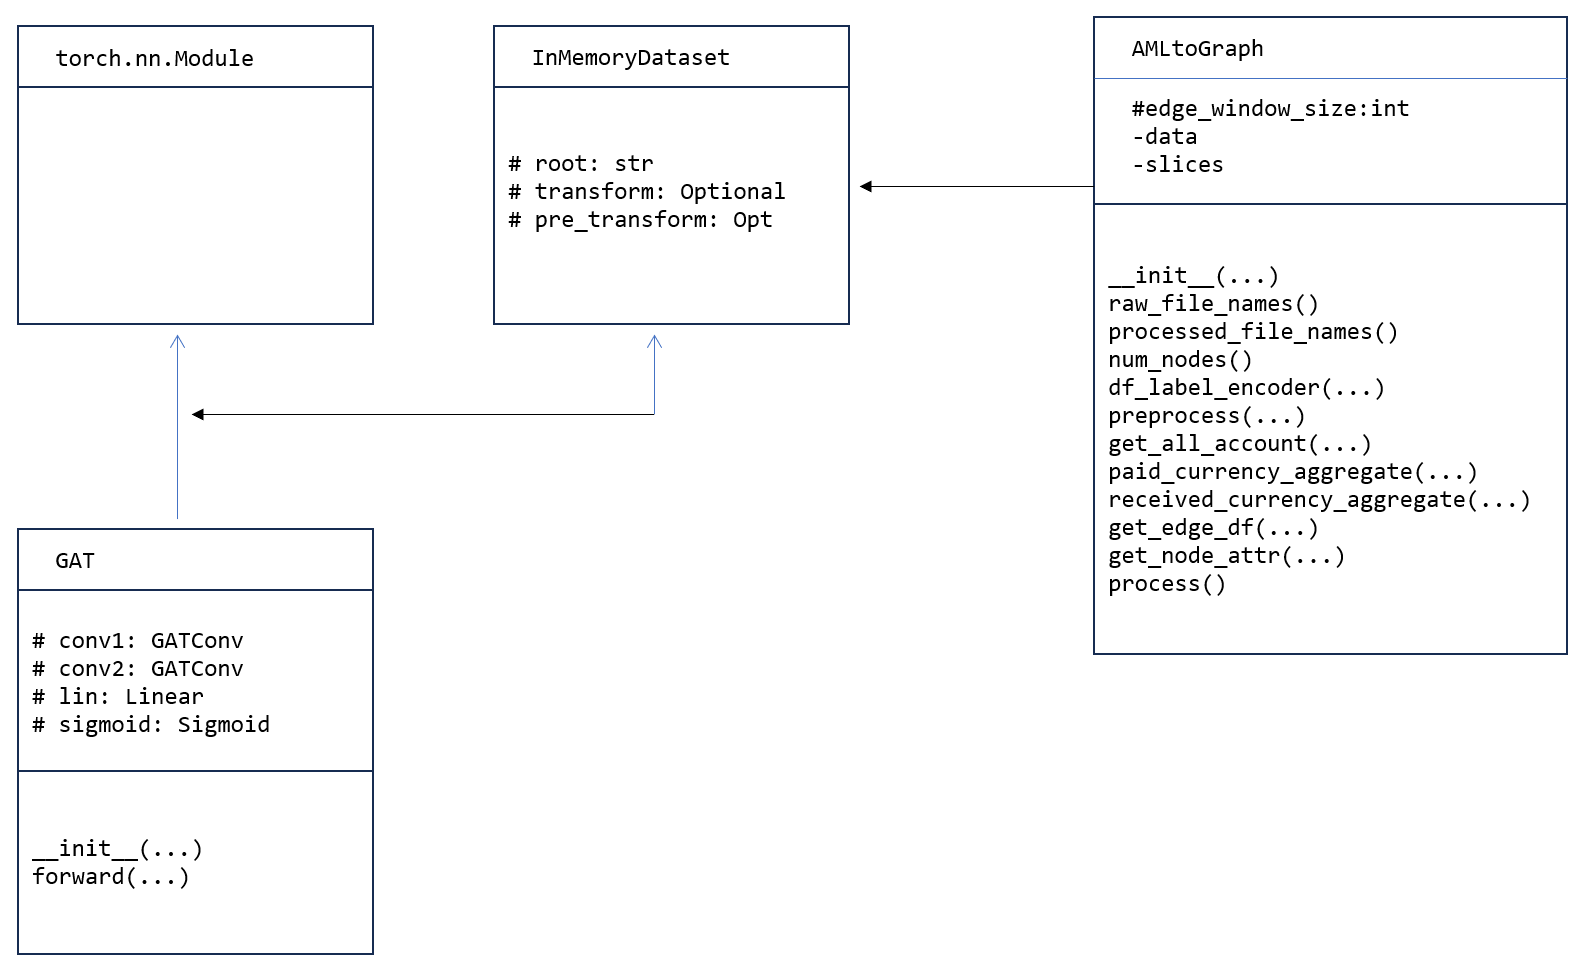